★実行環境の選択

In [18]:
# VSCodeの場合
# edi_flg = 1
# Googlre Colabの場合
edi_flg = 0

In [19]:
if edi_flg == 0:
  # GoogleColabにGitHubリポジトリをクローンする用
  %cd /content/My_Python_project

  from google.colab import auth
  auth.authenticate_user()
  !git clone https://github.com/keiseki-eng/My_Python_project
  !git pull origin main



/content/My_Python_project
Cloning into 'My_Python_project'...
remote: Enumerating objects: 1763, done.
remote: Counting objects: 100% (1763/1763), done.
remote: Compressing objects: 100% (1549/1549), done.
remote: Total 1763 (delta 265), reused 1655 (delta 188), pack-reused 0 (from 0)
Receiving objects: 100% (1763/1763), 10.57 MiB | 11.74 MiB/s, done.
Resolving deltas: 100% (265/265), done.
From https://github.com/keiseki-eng/My_Python_project
 * branch            main       -> FETCH_HEAD
Already up to date.


In [20]:
# import sys
# !{sys.executable} -m pip install ipykernel

In [21]:
if edi_flg == 0:
    !pip install japanize-matplotlib

import os
import sys
import yaml
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import japanize_matplotlib #日本語表示対応


# Notebook から src ディレクトリを追加
# sys.path.append(os.path.join(os.getcwd(), "src"))
sys.path.append("/home/keiseki/My_Python_project/src")

# これで src/preprocess/make_tag_features.py が import 可能
# from preprocess.make_tag_features import create_tag_features, extract_unique_tags

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=pd.errors.PerformanceWarning
)

## 01.config読み込み

In [24]:
# VSCode用
if edi_flg==1:
  conf_path = os.path.join( '../config/config.yaml')
  with open(conf_path, 'r') as f:
    config = yaml.safe_load(f)

# GoogleColab用
elif edi_flg==0:
  conf_path = "My_Python_project/config/config.yaml"
  with open(conf_path, "r") as f:
    config = yaml.safe_load(f)

In [25]:
# 定義した特徴量リストを読み込み
feature_list = config['FEATURE']['FEATURE_LIST']

In [26]:
# カテゴリカルカラムのリストを定義
categorical_cols = config['FEATURE']['CATEGORICAL_COLS']

## 02.データ読み込み

In [27]:
# VSCode用
if edi_flg==1:
# ドライブ内のファイルパスを指定
    train_path = '../20.Data/processed_train.pkl'
    df_train = pd.read_pickle(train_path)

# GoogleColab用
elif edi_flg==0:
    # GoogleDriveをマウントしてファイル読み込み準備
    from google.colab import drive
    drive.mount('/content/drive')
    # ドライブ内のファイルパスを指定
    train_path = '/content/drive/MyDrive/Colab Notebooks/不動産予測/processed_train.pkl'
    df_train = pd.read_pickle(train_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# testデータの読み込み
# VSCode用
if edi_flg==1:
    test_path = '../20.Data/processed_test.pkl'
    df_test = pd.read_pickle(test_path)

# GoogleColab用
elif edi_flg==0:
    # ドライブ内のファイルパスを指定
    test_path = '/content/drive/MyDrive/Colab Notebooks/不動産予測/processed_test.pkl'
    df_test = pd.read_pickle(test_path)

## ★うまく行けば特徴量作成ファイル、configに反映！価格帯のような特徴量を作成

In [29]:
# ===============================
# 擬似 price_band 作成（リークなし）
# ===============================

def make_pseudo_price(df):
    score = (
        # 面積（最重要）
        0.55 * np.log1p(df["unit_area"])

        # 駅距離（近いほど高い）
        - 0.30 * np.log1p(df["walk_distance1"] + 1)

        # 築年数（新しいほど高い）
        - 0.20 * np.log1p(df["building_age"] + 1)

        # 間取り数（部屋数が多いほど高い）
        + 0.15 * np.log1p(df["room_count"] + 1)
    )

    # walk_distance2 が存在すれば軽く効かせる
    # if "walk_distance2" in df.columns:
        # score -= 0.10 * np.log1p(df["walk_distance2"] + 1)

    return score

In [30]:
# 擬似 price スコア
df_train["pseudo_price"] = make_pseudo_price(df_train)
df_test["pseudo_price"] = make_pseudo_price(df_test)

# train の分位点で price_band を作る（重要）
bins = pd.qcut(df_train["pseudo_price"], q=5, retbins=True)[1]

df_train["pseudo_price_band"] = pd.cut(
    df_train["pseudo_price"], bins=bins, labels=False, include_lowest=True
)

df_test["pseudo_price_band"] = pd.cut(
    df_test["pseudo_price"], bins=bins, labels=False, include_lowest=True
)

In [31]:
feature_list = feature_list + ["pseudo_price_band"]
categorical_cols = categorical_cols + ["pseudo_price_band"]


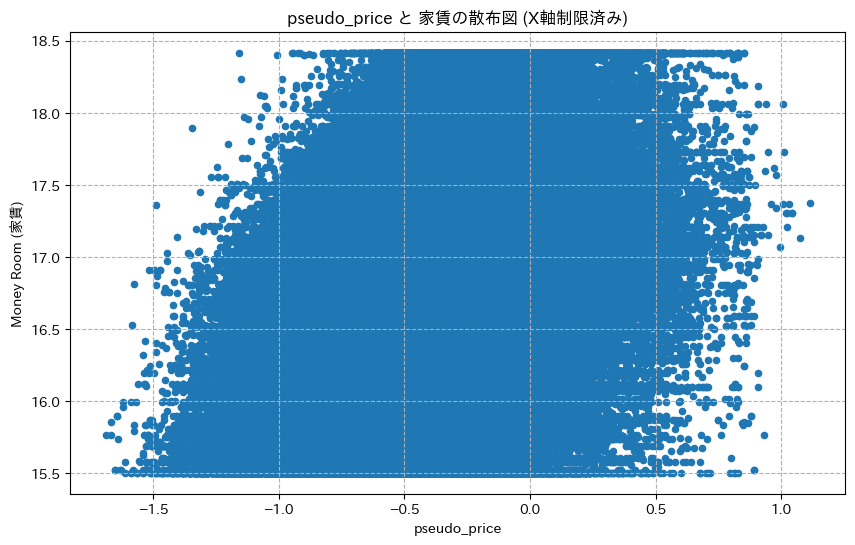

In [32]:
# 検証メモ：疑似スコアは売買価格と似てるのか
target_feature = "pseudo_price"

df_train["money_room"] = np.log1p(df_train["money_room"])

# データの描画
# plot.scatterの返り値はAxesオブジェクトなので、変数axに格納すると便利
ax = df_train.plot.scatter(x=target_feature, y="money_room", figsize=(10, 6))

# 🔑 X軸の表示範囲を設定（例: 0から2000平方メートルに制限する場合）
# 制限したい最小値と最大値をタプルまたはリストで指定します
# x_min = 50
# x_max = 150
# plt.xlim((x_min, x_max))

# タイトルやラベルの設定（任意）
plt.title(f"{target_feature} と 家賃の散布図 (X軸制限済み)")
plt.xlabel(f"{target_feature}")
plt.ylabel("Money Room (家賃)")
plt.grid(True, linestyle='--')

plt.show()

In [33]:
df_train["money_room"]

,money_room
0,16.453138
1,17.013367
2,17.013367
3,16.606676
4,16.749367
...,...
363919,16.475770
363920,16.754673
363921,16.581830
363922,17.682536


In [34]:
df_train["pseudo_price"]

,pseudo_price
0,-0.465805
1,-0.354750
2,-0.452521
3,-0.167488
4,-0.192849
...,...
363919,-0.429358
363920,0.038179
363921,-0.538124
363922,-0.440110
